In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import time
import psutil
import threading
from memory_profiler import memory_usage

In [ ]:
import glob

files = glob.glob('*TrafficForML_CICFlowMeter.csv')

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

df.to_csv('combined_traffic_data.csv', index=False)

C:\Users\Pavel\AppData\Local\Temp\ipykernel_13508\636553578.py:5: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


In [ ]:
df.shape

(16233002, 84)

In [2]:
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5): 
    measurement_rf = {}
        
    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs, verbose=1)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_model()
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        import traceback
        print("⛔ Full error traceback:")
        traceback.print_exc()  # Print detailed error traceback
        print(f"Error during Random Forest training: {e}")
        return None, None, None

In [3]:
def eval_dataset_w_RF(df, target_column="Label"):
    X = df.drop(target_column, axis=1)
    y = df[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    params_rf = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

    # Fitting the model
    cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train, y_train, best_params=params_rf)

    # Making predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Evaluating the model performance on the cross validation set vs accuracy on the test set
    cv_scores_mean_rf = np.mean(cv_scores_rf)
    print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f'Accuracy on the test set: {accuracy_rf:.4f}')
    
    # Checking computational cost
    print("Resource measurements:", measurement_rf)
    print(classification_report(y_test, y_pred_rf))

In [4]:
def get_feature_types(df, target_col='Label'):
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [5]:
df = pd.read_csv("combined_traffic_data.csv")

C:\Users\Pavel\AppData\Local\Temp\ipykernel_25540\2503161614.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_traffic_data.csv")


In [6]:
df.shape

(16233002, 84)

In [7]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Flow ID,Src IP,Src Port,Dst IP
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232997,23,6,28/02/2018 11:59:12,3,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN
16232998,425,6,28/02/2018 10:50:04,2,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN
16232999,445,6,28/02/2018 12:52:55,732728,2,2,0,0,0,0,...,0,0,0.0,0,0,Benign,NaN,NaN,NaN,NaN
16233000,23,6,28/02/2018 11:10:50,22,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16233002 entries, 0 to 16233001
Data columns (total 84 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           object 
 1   Protocol           object 
 2   Timestamp          object 
 3   Flow Duration      object 
 4   Tot Fwd Pkts       object 
 5   Tot Bwd Pkts       object 
 6   TotLen Fwd Pkts    object 
 7   TotLen Bwd Pkts    object 
 8   Fwd Pkt Len Max    object 
 9   Fwd Pkt Len Min    object 
 10  Fwd Pkt Len Mean   object 
 11  Fwd Pkt Len Std    object 
 12  Bwd Pkt Len Max    object 
 13  Bwd Pkt Len Min    object 
 14  Bwd Pkt Len Mean   object 
 15  Bwd Pkt Len Std    object 
 16  Flow Byts/s        object 
 17  Flow Pkts/s        object 
 18  Flow IAT Mean      object 
 19  Flow IAT Std       object 
 20  Flow IAT Max       object 
 21  Flow IAT Min       object 
 22  Fwd IAT Tot        object 
 23  Fwd IAT Mean       object 
 24  Fwd IAT Std        object 
 25  Fwd IAT Max     

In [10]:
# Dropping non helpful columns
df.drop(["Timestamp", "Flow ID", "Src IP", "Src Port", "Dst IP"], axis=1, inplace=True)

In [11]:
df.shape

(16233002, 79)

In [12]:
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.strip()

In [13]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [14]:
df["Label"].unique()[1:]

array(['Bot', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label',
       'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection',
       'DDoS attacks-LOIC-HTTP', 'Infilteration', 'DoS attacks-GoldenEye',
       'DoS attacks-Slowloris', 'FTP-BruteForce', 'SSH-Bruteforce',
       'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC'], dtype=object)

In [15]:
labels = df["Label"]
df.drop("Label", axis=1, inplace=True)
for column in df.columns:
   df[column] = pd.to_numeric(df[column], errors='coerce')
df["Label"] = labels
del labels

Features with at least one NaN or Infinity value:
Dst Port         59
Protocol         59
Flow Duration    59
Tot Fwd Pkts     59
Tot Bwd Pkts     59
                 ..
Active Min       59
Idle Mean        59
Idle Std         59
Idle Max         59
Idle Min         59
Length: 78, dtype: int64


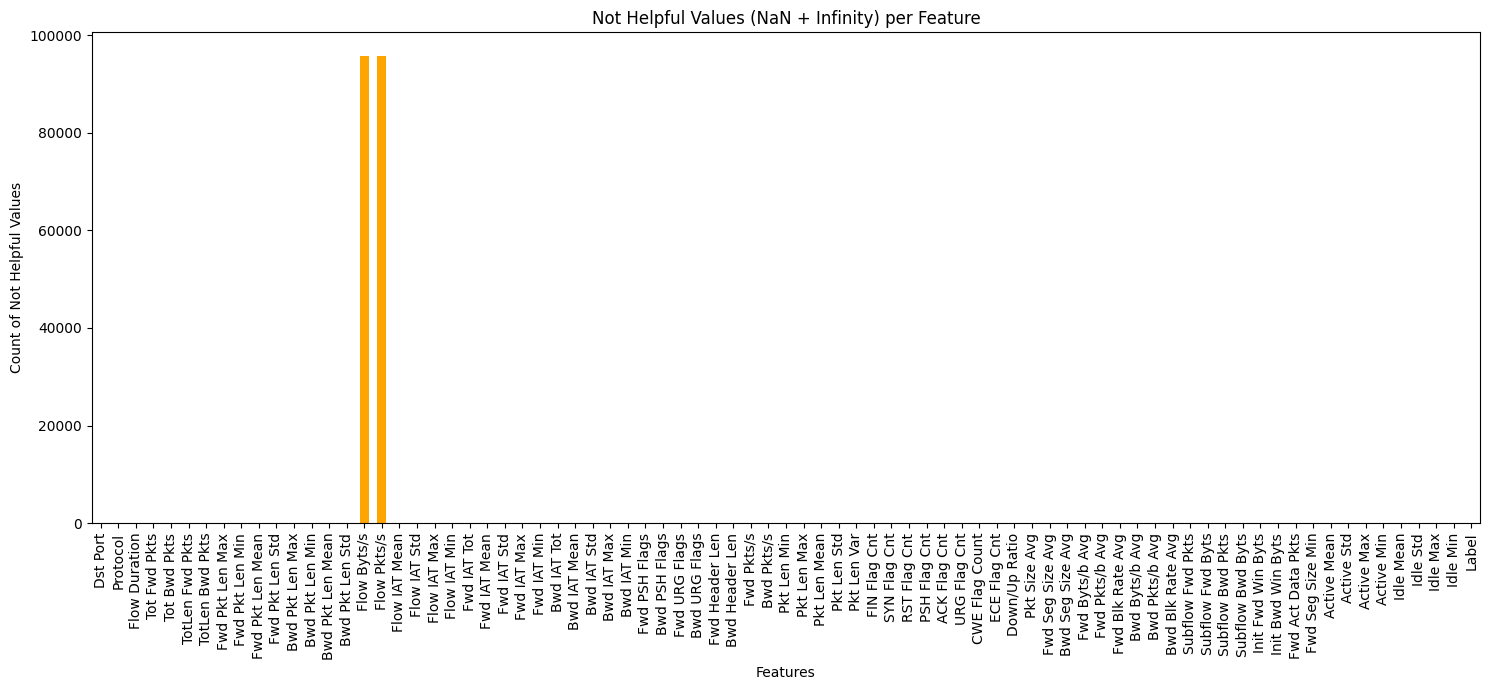

In [16]:
nan_counts = df.isna().sum()
def count_infs(col):
    if pd.api.types.is_numeric_dtype(col):
        return np.isinf(col).sum()
    else:
        return 0
inf_counts = df.apply(count_infs)
not_helpful_counts = nan_counts + inf_counts
features_with_issue = not_helpful_counts[not_helpful_counts > 0]
print("Features with at least one NaN or Infinity value:")
print(features_with_issue)
plt.figure(figsize=(15, 7))
not_helpful_counts.plot(kind='bar', color='orange')
plt.title("Not Helpful Values (NaN + Infinity) per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Not Helpful Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Byts/s    36039
Flow Pkts/s    95760
dtype: int64


In [18]:
# Treating infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,Benign,13484708,13390249.0,94459.0,0.7
1,DDOS attack-HOIC,686012,686012.0,0.0,0.0
2,DDoS attacks-LOIC-HTTP,576191,576191.0,0.0,0.0
3,DoS attacks-Hulk,461912,461912.0,0.0,0.0
4,Bot,286191,286191.0,0.0,0.0
5,FTP-BruteForce,193360,193354.0,6.0,0.0
6,SSH-Bruteforce,187589,187589.0,0.0,0.0
7,Infilteration,161934,160639.0,1295.0,0.8
8,DoS attacks-SlowHTTPTest,139890,139890.0,0.0,0.0
9,DoS attacks-GoldenEye,41508,41508.0,0.0,0.0


In [20]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [21]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    1.623300e+07
mean     1.529327e-02
std      2.701965e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.873418e+01
dtype: float64

Total rows with missing values: 95819


In [22]:
# Dropping missing values
df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

Dataset shape after row-wise removal: (16137183, 79)


In [23]:
nan_counts = df.isna().sum()
inf_counts = df.apply(count_infs)
print("Features with NaNs")
print(nan_counts[nan_counts>0])
print("Features with Infs")
print(inf_counts[inf_counts>0])

Features with NaNs
Series([], dtype: int64)
Features with Infs
Series([], dtype: int64)


In [24]:
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443.0,6.0,141385.0,9.0,7.0,553.0,3773.0,202.0,0.0,61.444444,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684.0,6.0,281.0,2.0,1.0,38.0,0.0,38.0,0.0,19.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443.0,6.0,279824.0,11.0,15.0,1086.0,10527.0,385.0,0.0,98.727273,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443.0,6.0,132.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443.0,6.0,274016.0,9.0,13.0,1285.0,6141.0,517.0,0.0,142.777778,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232997,23.0,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration
16232998,425.0,6.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration
16232999,445.0,6.0,732728.0,2.0,2.0,0.0,0.0,0.0,0.0,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
16233000,23.0,6.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration


In [25]:
df.shape

(16137183, 79)

In [26]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

count    16137183.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
dtype: float64


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16137183 entries, 0 to 16233001
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float64
 1   Protocol           float64
 2   Flow Duration      float64
 3   Tot Fwd Pkts       float64
 4   Tot Bwd Pkts       float64
 5   TotLen Fwd Pkts    float64
 6   TotLen Bwd Pkts    float64
 7   Fwd Pkt Len Max    float64
 8   Fwd Pkt Len Min    float64
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    float64
 12  Bwd Pkt Len Min    float64
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       float64
 20  Flow IAT Min       float64
 21  Fwd IAT Tot        float64
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        float64
 25  Fwd IAT Min        fl

In [ ]:
df.to_csv('combined_data_fixed.csv', index=False)

In [28]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.5min finished


⛔ Full error traceback:


Traceback (most recent call last):
  File "C:\Users\Pavel\AppData\Local\Temp\ipykernel_25540\3998743185.py", line 41, in apply_rf
    cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 328, in cross_validate
    _warn_or_raise_about_fit_failures(results, error_score)
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\s

Error during Random Forest training: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
           ^^^^^^
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 589, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

In [ ]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))
df['Label'].value_counts()

In [ ]:
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [ ]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"Without duplicate rows shape: {df.shape}")

In [ ]:
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

In [ ]:
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

In [ ]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [ ]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)